# MatMul Analysis of multiple Matrix Size

In [2]:
import glob
from matplotlib import pyplot as plt
import os
from pprint import pprint

In [3]:
data = {}

for filename in glob.glob("./results/sim_480/*.txt"):
    size, _ = os.path.splitext(filename.split("-")[-1])
    size = int(size)
    if size not in (32, 64, 128, 256, 512):
        continue
    if size not in data.keys():
        data[size] = {}
    with open(filename) as f:
        data[size]["raw"] = f.readlines()

In [4]:
def find_lines(file_content: [str],pattern: str) -> [str]:
    result = []
    for line in file_content:
        if pattern in line:
            result.append(line)
    return result


def find_line(file_content: [str], pattern: str) -> str:
    for line in file_content:
        if pattern in line:
            return line
    return ""

In [5]:
# Plot execution time
for size in sorted(data.keys()):
    # Simulation Time
    data[size]["time"] = int(find_line(data[size]["raw"], "gpgpu_simulation_time").split("(")[1][:-1].split(" ")[0])

    # IPC
    data[size]["IPC"] = float(find_line(data[size]["raw"], "gpu_ipc").strip().split("=")[1].strip())
    
    # Execution time (sim_cycles/core_frequency)
    clock_cycles = int(find_line(data[size]["raw"], "gpu_sim_cycle").strip().split("=")[1])
    core_freq = float(find_line(data[size]["raw"], "gpgpu_clock_domains").split()[1].split(":")[0]) * 1e6  # clock is in MHz
    data[size]["exec"] = clock_cycles/core_freq

    # FLOP/s
    data[size]["flops"] = (size ** 2 * (2 * size)) / data[size]["exec"]

    # DRAM Bandwidth (bit/s) = access_width * clock * #memory
    DRAM_Clock = float(find_line(data[size]["raw"], "gpgpu_clock_domains").split()[1].split(":")[-1]) * 1e6  # clock is in MHz
    gpgpu_dram_buswidth = int(find_line(data[size]["raw"], "gpgpu_dram_buswidth").split()[1])  # gpgpu_dram_buswidth is in bytes
    gpgpu_n_mem = int(find_line(data[size]["raw"], "gpgpu_n_mem").split()[1])
    gpgpu_n_mem_per_ctrlr = int(find_line(data[size]["raw"], "gpgpu_n_mem_per_ctrlr").split()[1])

    peak_bw = (gpgpu_n_mem * gpgpu_n_mem_per_ctrlr * gpgpu_dram_buswidth * DRAM_Clock * 2) / 1e9  # GBytes/s

    average_utilization = [float(ut.strip().split("=")[-1]) for ut in find_lines(data[size]["raw"], "bw_util")]
    average_utilization = sum(average_utilization) / len(average_utilization)

    data[size]["DRAM_bw"] = peak_bw * average_utilization

    data[size]["occupancy"] = float(find_line(data[size]["raw"], "gpu_occupancy =").strip().split("=")[1][:-1])

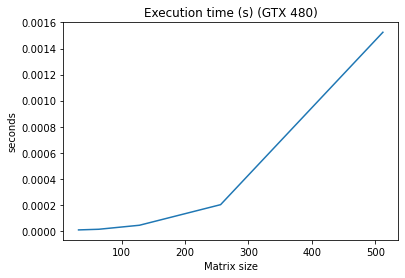

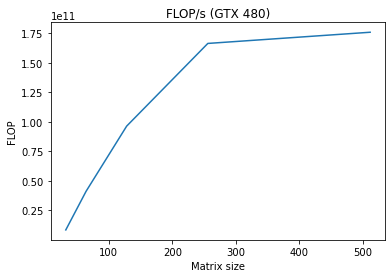

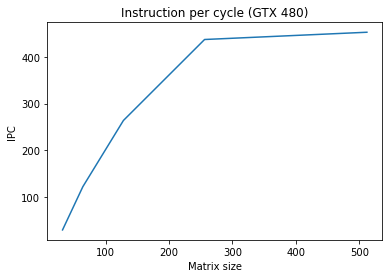

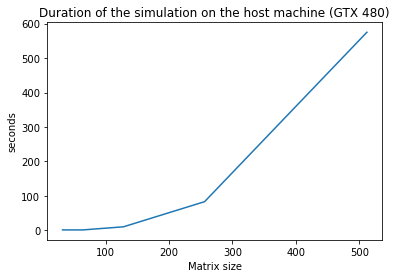

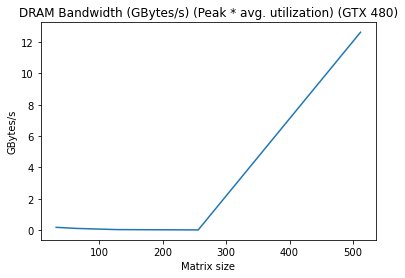

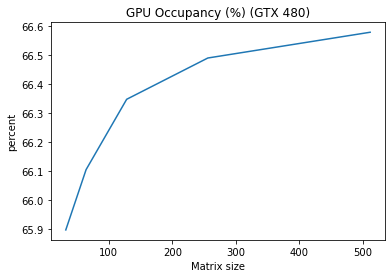

In [7]:
DPI=128

# A) Execution Time
plt.plot(sorted(data.keys()), [data[size]["exec"] for size in sorted(data.keys())])
plt.title('Execution time (s) (GTX 480)')
plt.xlabel('Matrix size')
plt.ylabel('seconds')
plt.savefig("plots/a-exec_time-480.png", transparent=False, dpi=DPI)
plt.show()

# B) FLOP/s
plt.plot(sorted(data.keys()), [data[size]["flops"] for size in sorted(data.keys())])
plt.title('FLOP/s (GTX 480)')
plt.xlabel('Matrix size')
plt.ylabel('FLOP')
plt.savefig("plots/b-flop_per_s-480.png", transparent=False, dpi=DPI)
plt.show()

# C) IPC
plt.plot(sorted(data.keys()), [data[size]["IPC"] for size in sorted(data.keys())])
plt.title('Instruction per cycle (GTX 480)')
plt.xlabel('Matrix size')
plt.ylabel('IPC')
plt.savefig("plots/c-ipc-480.png", transparent=False, dpi=DPI)
plt.show()

# D) Simulation Time
plt.plot(sorted(data.keys()), [data[size]["time"] for size in sorted(data.keys())])
plt.title('Duration of the simulation on the host machine (GTX 480)')
plt.xlabel('Matrix size')
plt.ylabel('seconds')
plt.savefig("plots/d-sim_time-480.png", transparent=False, dpi=DPI)
plt.show()

# E) External Bandwidth
plt.plot(sorted(data.keys()), [data[size]["DRAM_bw"] for size in sorted(data.keys())])
plt.title('DRAM Bandwidth (GBytes/s) (Peak * avg. utilization) (GTX 480)')
plt.xlabel('Matrix size')
plt.ylabel('GBytes/s')
plt.savefig("plots/e-ext_bw-480.png", transparent=False, dpi=DPI)
plt.show()

# F) GPU Occupancy
plt.plot(sorted(data.keys()), [data[size]["occupancy"] for size in sorted(data.keys())])
plt.title('GPU Occupancy (%) (GTX 480)')
plt.xlabel('Matrix size')
plt.ylabel('percent')
plt.savefig("plots/f-occupancy-480.png", transparent=False, dpi=DPI)
plt.show()